<a href="https://www.kaggle.com/code/rayyan123z/knowledge-graph-clustering?scriptVersionId=157056358" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import spacy
nlp = spacy.load('en_core_web_sm')
import re
import string
from spacy.lang.en import English
import networkx as nx
import matplotlib.pyplot as plt
import nltk
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from spacy.matcher import Matcher 
from spacy.tokens import Span
from tqdm import tqdm
import bs4
import requests
from spacy import displacy

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/religion/Text based Religion Posts 35000.csv


# Preprocessing Functions

In [2]:
def get_entities(sent):
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""  # dependency tag of the previous token in the sentence
    prv_tok_text = ""  # the previous token in the sentence

    prefix = ""
    modifier = ""

    for tok in nlp(sent):
        # if the token is a punctuation mark, then move on to the next token
        if tok.dep_ != "punct":
            # check if the token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound', then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text
            # check if the token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound', then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text
            # check if the token is a subject
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""
            # check if the token is an object
            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text

    return [ent1.strip(), ent2.strip()]


In [3]:
def clean_text(x):
    text = re.sub('(\d+)','',x)   
    text = text.lower()
    return text
def remove_url(x):
    text = re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})\/([a-zA-Z0-9_]+]*)',' ',x)
    return text
def remove_punct(x):
    text_without_puct = [t for t in x if t not in string.punctuation]
    text_without_puct = ''.join(text_without_puct)
    return text_without_puct
stop_words = nltk.corpus.stopwords.words('english')
from nltk.corpus import stopwords
stop = stopwords.words('english')


In [4]:
def get_relation(sent):
    doc = nlp(sent)

    # Matcher class object
    matcher = Matcher(nlp.vocab)

    # Define the pattern
    pattern = [{'DEP': 'ROOT'},
               {'DEP': 'prep', 'OP': "?"},
               {'DEP': 'agent', 'OP': "?"},
               {'POS': 'ADJ', 'OP': "?"}]

    # Wrap the pattern in a list when adding to the Matcher
    matcher.add("matching_1", [pattern])

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]]

    return span.text

# EDA

In [5]:
df = pd.read_csv(r'/kaggle/input/religion/Text based Religion Posts 35000.csv')
df.head()

index                                           Document subreddit
0  527941  I was raised as a Muslim, but never got into t...     islam
1  534235  \nAs salamu alaikum, I wonder what the benefit...     islam
2  531104  I was at a coffee shop when I saw a carbonara ...     islam
3  525922  Hello, so I am a 13 year old boy, naturally I ...     islam
4  523640  We intend to get married soon but my father an...     islam

In [6]:
df.shape

(35000, 3)

In [7]:
df['subreddit'].value_counts()

subreddit
islam              11000
Christianity        4000
atheism             4000
hinduism            4000
exmuslim            2000
Muslim              1000
food                 700
Pets                 700
gaming               700
personalfinance      700
travel               700
Fitness              700
politics             700
sports               700
AskReddit            600
science              600
television           600
technology           600
MuslimMarriage       500
Hijabis              500
Name: count, dtype: int64

In [8]:
df.isnull().sum()

index        0
Document     0
subreddit    0
dtype: int64

In [9]:
df.duplicated().sum()

0

In [10]:
isl = df[df['subreddit'] == 'islam'].head(50)
chris = df[df['subreddit'] == 'Christianity'].head(50)
hindu = df[df['subreddit'] == 'hinduism'].head(50)
new_df = pd.concat([isl, chris, hindu], ignore_index=True)

In [11]:
new_df

index                                           Document subreddit
0    527941  I was raised as a Muslim, but never got into t...     islam
1    534235  \nAs salamu alaikum, I wonder what the benefit...     islam
2    531104  I was at a coffee shop when I saw a carbonara ...     islam
3    525922  Hello, so I am a 13 year old boy, naturally I ...     islam
4    523640  We intend to get married soon but my father an...     islam
..      ...                                                ...       ...
145   22095  Hello again, r/Hinduism! So I am an American m...  hinduism
146   22844  I am looking for suggestions on a great, accur...  hinduism
147   21614  So, it is known that if a person does somethin...  hinduism
148   22731  I've seen my parents worshipping god as ideal/...  hinduism
149   24760  A boy asked the father: What’s the size of God...  hinduism

[150 rows x 3 columns]

# Preproccesing

In [12]:
y = new_df.pop('subreddit')
new_df = new_df.drop('index' , axis = 1)

In [13]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... compound
d823 ... pobj


In [14]:
new_df

Document
0    I was raised as a Muslim, but never got into t...
1    \nAs salamu alaikum, I wonder what the benefit...
2    I was at a coffee shop when I saw a carbonara ...
3    Hello, so I am a 13 year old boy, naturally I ...
4    We intend to get married soon but my father an...
..                                                 ...
145  Hello again, r/Hinduism! So I am an American m...
146  I am looking for suggestions on a great, accur...
147  So, it is known that if a person does somethin...
148  I've seen my parents worshipping god as ideal/...
149  A boy asked the father: What’s the size of God...

[150 rows x 1 columns]

In [15]:
new_df['Document'] = new_df['Document'].apply(clean_text)
new_df['Document'] = new_df['Document'].apply(remove_url)
new_df['Document'] = new_df['Document'].apply(remove_punct)
new_df['Document'] = new_df['Document'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [16]:
new_df

Document
0    raised muslim never got habit praying five tim...
1    salamu alaikum wonder benefits umrah hajj peop...
2    coffee shop saw carbonara pasta asked pork cas...
3    hello year old boy naturally sexual desires le...
4    intend get married soon father live great dist...
..                                                 ...
145  hello rhinduism american married hindu family ...
146  looking suggestions great accurate bhagavad gi...
147  known person something bad sets negative force...
148  ive seen parents worshipping god ideal person ...
149  boy asked father what’s size god father looked...

[150 rows x 1 columns]

In [17]:
entity_pairs = []

for i in tqdm(new_df["Document"]):
    entity_pairs.append(get_entities(i))

100%|██████████| 150/150 [00:04<00:00, 34.14it/s]


In [18]:
entity_pairs

[['helpless salah build days', 'mindful salah build stuff'],
 ['prepared hajj thanks that', 'prepared hajj thanks contributions'],
 ['anyway  thoughts', 'sick  eating'],
 ['see doctor saudi arabia', 'probably halal way'],
 ['islamic  law', 'current person circumstances'],
 ['ashamed allah i', 'nature jazak'],
 ['beautiful  religion', 'strange  disrespectful'],
 ['terrorist army god', 'armyofgodusa hutaree'],
 ['anbiyā āyat animals', 'goto heaven'],
 ['i', 'specific  recipes'],
 ['many  muslims', 'question advice'],
 ['count i', 'count promise'],
 ['even city position', 'country'],
 ['missed payment obligations', 'help'],
 ['well efforts s', 'even efforts time'],
 ['well  knowledge', 'mindful  edit'],
 ['i d', 'side'],
 ['emotions editor', 'portray stance'],
 ['peaceful videos topic world', 'terrorism myth'],
 ['forever  ️', 'listening story'],
 ['wrong  forehead', 'totally  salam'],
 ['bigger  depth', 'major bit reason'],
 ['sincerely way antithesis', 'post'],
 ['probably  s', 'terribl

In [19]:
relations = [get_relation(i) for i in tqdm(new_df['Document'])]


100%|██████████| 150/150 [00:03<00:00, 41.08it/s]


In [20]:
additional_df = pd.DataFrame(entity_pairs, columns=['Subject' , 'Object'])
additional_df['relations'] = relations

In [21]:
concatenated_df = pd.concat([new_df, additional_df], axis=1)

In [22]:
concatenated_df.head()

Document  \
0  raised muslim never got habit praying five tim...   
1  salamu alaikum wonder benefits umrah hajj peop...   
2  coffee shop saw carbonara pasta asked pork cas...   
3  hello year old boy naturally sexual desires le...   
4  intend get married soon father live great dist...   

                     Subject                              Object relations  
0  helpless salah build days           mindful salah build stuff      came  
1  prepared hajj thanks that  prepared hajj thanks contributions      save  
2           anyway  thoughts                        sick  eating       saw  
3    see doctor saudi arabia                  probably halal way    handle  
4               islamic  law        current person circumstances   married

In [23]:
words_to_count = ['salah' , 'quran' , 'five' , 'umrah' , 'hajj' 'haram' 
                  ,'islam','muslim','allah', 'muslims', 'religion','islamic', 'school',
                  'brothers','quran','prophet','woman','faith', 'prayers', 'ramadan' ,'pork']
concatenated_df['word_islam'] = concatenated_df['Document'].apply(
    lambda x: sum(x.lower().split().count(word) for word in words_to_count)
)

In [24]:
words_to_count = ['hinduism', 'hindu', 'lord', 'gita','consciousness', 'kṛṣṇa', 'bhagavad',
                  'gods', 'yoga', 'shiva','krishna', 'temple', 'vedas', 'hanuman','india','worship','ganesha']
concatenated_df['word_hinduism'] = concatenated_df['Document'].apply(
    lambda x: sum(x.lower().split().count(word) for word in words_to_count)
)

In [25]:
words_to_count = ['christan', 'jesus' ,'church', 'bible', 'christ' 'christianity', 'christians','sin' , 'atheist']
concatenated_df['word_christan'] = concatenated_df['Document'].apply(
    lambda x: sum(x.lower().split().count(word) for word in words_to_count)
)

In [26]:
concatenated_df

Document  \
0    raised muslim never got habit praying five tim...   
1    salamu alaikum wonder benefits umrah hajj peop...   
2    coffee shop saw carbonara pasta asked pork cas...   
3    hello year old boy naturally sexual desires le...   
4    intend get married soon father live great dist...   
..                                                 ...   
145  hello rhinduism american married hindu family ...   
146  looking suggestions great accurate bhagavad gi...   
147  known person something bad sets negative force...   
148  ive seen parents worshipping god ideal person ...   
149  boy asked father what’s size god father looked...   

                                               Subject  \
0                            helpless salah build days   
1                            prepared hajj thanks that   
2                                     anyway  thoughts   
3                              see doctor saudi arabia   
4                                         islamic  law   
..                                                 ...   
145                                 also ram rama baba   
146  compared translationscommentaries vedanta scho...   
147                           later victim crime karma   
148                 comprehensible manifest reach goal   
149                                       huge  father   

                                 Object    relations  word_islam  \
0             mindful salah build stuff         came          16   
1    prepared hajj thanks contributions         save           3   
2                          sick  eating          saw           4   
3                    probably halal way       handle           1   
4          current person circumstances      married           1   
..                                  ...          ...         ...   
145                                rama  felt strong           0   
146                      greatly  thank       prefer           0   
147            often victim crime crime       affect           0   
148                             brahman         seen           1   
149                   🙏 🙏 🙏 explanation        asked           0   

     word_hinduism  word_christan  
0                0              0  
1                0              0  
2                0              0  
3                0              1  
4                0              0  
..             ...            ...  
145              2              0  
146              2              0  
147              0              0  
148              2              1  
149              0              0  

[150 rows x 7 columns]

In [27]:
concatenated_df.drop('Document' , inplace = True , axis = 1)

# Knowledge Graph

In [28]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()
for i ,row in concatenated_df.head(30).iterrows():
    G.add_edge(row['Subject'] , row['Object'] , label = row['relations'])

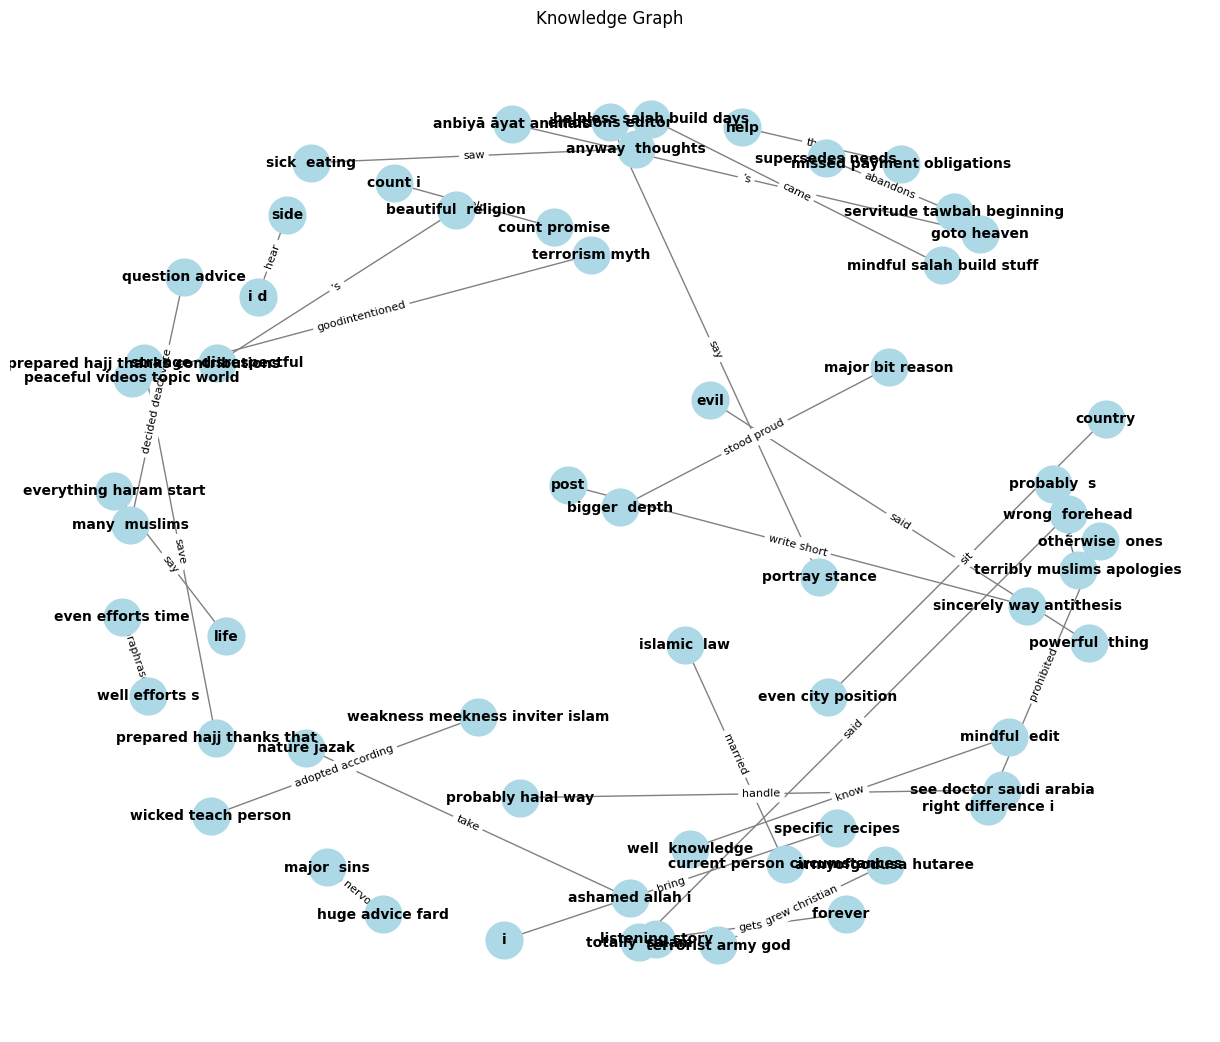

In [29]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming G is your graph and has nodes, edges, and edge labels

# Set the seed for reproducibility
pos = nx.spring_layout(G, seed=42, k=0.9)

# Get edge labels
labels = nx.get_edge_attributes(G, 'label')

# Create a figure and set the size
plt.figure(figsize=(12, 10))

# Draw nodes and edges with labels
nx.draw(G, pos, with_labels=True, font_size=10, node_size=700, node_color='lightblue', font_color='black', font_weight='bold', edge_color='gray')

# Draw networkx edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8, label_pos=0.5)

# Set the title
plt.title('Knowledge Graph')

# Show the plot
plt.show()


In [30]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f'Number of nodes: {num_nodes}')
print(f'Number of edges: {num_edges}')
print(f'Ratio edges to nodes: {round(num_edges / num_nodes, 2)}')

Number of nodes: 60
Number of edges: 30
Ratio edges to nodes: 0.5


In [31]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()
for i ,row in concatenated_df.iterrows():
    G.add_edge(row['Subject'] , row['Object'] , label = row['relations'])

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128591 (\N{PERSON WITH FOLDED HANDS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


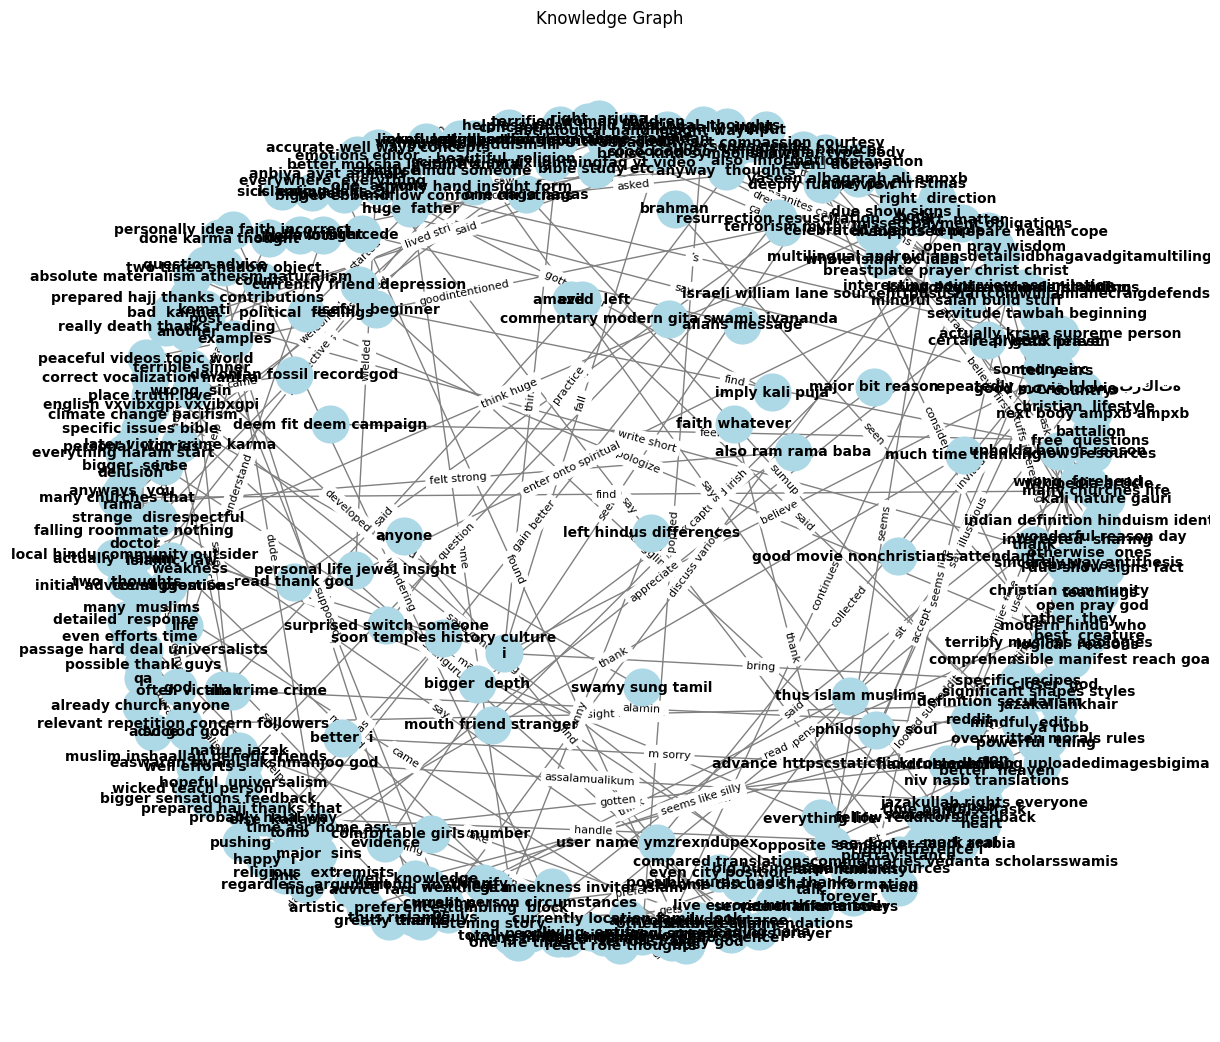

In [32]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming G is your graph and has nodes, edges, and edge labels

# Set the seed for reproducibility
pos = nx.spring_layout(G, seed=42, k=0.9)

# Get edge labels
labels = nx.get_edge_attributes(G, 'label')

# Create a figure and set the size
plt.figure(figsize=(12, 10))

# Draw nodes and edges with labels
nx.draw(G, pos, with_labels=True, font_size=10, node_size=700, node_color='lightblue', font_color='black', font_weight='bold', edge_color='gray')

# Draw networkx edge labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8, label_pos=0.5)

# Set the title
plt.title('Knowledge Graph')

# Show the plot
plt.show()


In [33]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
print(f'Number of nodes: {num_nodes}')
print(f'Number of edges: {num_edges}')
print(f'Ratio edges to nodes: {round(num_edges / num_nodes, 2)}')

Number of nodes: 288
Number of edges: 148
Ratio edges to nodes: 0.51


# Node Centrality Analysis

In [34]:
degree_centrality = nx.degree_centrality(G)
for node, centrality in degree_centrality.items():
    if centrality > 0:
        print(f'{node}: Degree Centrality = {centrality:.3f}')

helpless salah build days: Degree Centrality = 0.003
mindful salah build stuff: Degree Centrality = 0.003
prepared hajj thanks that: Degree Centrality = 0.003
prepared hajj thanks contributions: Degree Centrality = 0.003
anyway  thoughts: Degree Centrality = 0.003
sick  eating: Degree Centrality = 0.003
see doctor saudi arabia: Degree Centrality = 0.003
probably halal way: Degree Centrality = 0.003
islamic  law: Degree Centrality = 0.003
current person circumstances: Degree Centrality = 0.003
ashamed allah i: Degree Centrality = 0.003
nature jazak: Degree Centrality = 0.003
beautiful  religion: Degree Centrality = 0.003
strange  disrespectful: Degree Centrality = 0.003
terrorist army god: Degree Centrality = 0.003
armyofgodusa hutaree: Degree Centrality = 0.003
anbiyā āyat animals: Degree Centrality = 0.003
goto heaven: Degree Centrality = 0.003
i: Degree Centrality = 0.021
specific  recipes: Degree Centrality = 0.003
many  muslims: Degree Centrality = 0.003
question advice: Degree Cen

In [35]:
betweenness_centrality = nx.betweenness_centrality(G)
for node, centrality in betweenness_centrality.items():
    if centrality > 0:
        print(f'Betweenness Centrality of {node}: {centrality:3f}')

Betweenness Centrality of i: 0.000365
Betweenness Centrality of thanks: 0.000024
Betweenness Centrality of people: 0.000024
Betweenness Centrality of rama: 0.000024


In [54]:
closeness_centrality = nx.closeness_centrality(G)
for node, centrality in closeness_centrality.items():
    if centrality > 0.004:
        print(f'Closeness Centrality of {node}: {centrality:.3f}')

Closeness Centrality of i: 0.021
Closeness Centrality of specific  recipes: 0.011
Closeness Centrality of terrible  sinner: 0.011
Closeness Centrality of examples: 0.005
Closeness Centrality of thanks: 0.007
Closeness Centrality of doctor: 0.011
Closeness Centrality of tell years: 0.011
Closeness Centrality of people: 0.007
Closeness Centrality of react role thoughts: 0.005
Closeness Centrality of studysocial thing suggestions: 0.011
Closeness Centrality of rama: 0.007
Closeness Centrality of lot importance avatara: 0.005
Closeness Centrality of detailed  response: 0.005
Closeness Centrality of gita: 0.005
Closeness Centrality of soooooooooo: 0.011
Closeness Centrality of also ram rama baba: 0.005


# Clustering

In [37]:
pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.2 MB/s eta 0:00:0000:01
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
ydata-profiling 4.5.1 requires numpy<1.24,>=1.16.0, but you have numpy 1.24.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


Computing transition probabilities:   0%|          | 0/288 [00:00<?, ?it/s]

Generating walks (CPU: 3): 100%|██████████| 50/50 [00:04<00:00, 11.78it/s]
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128591 (\N{PERSON WITH FOLDED HANDS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


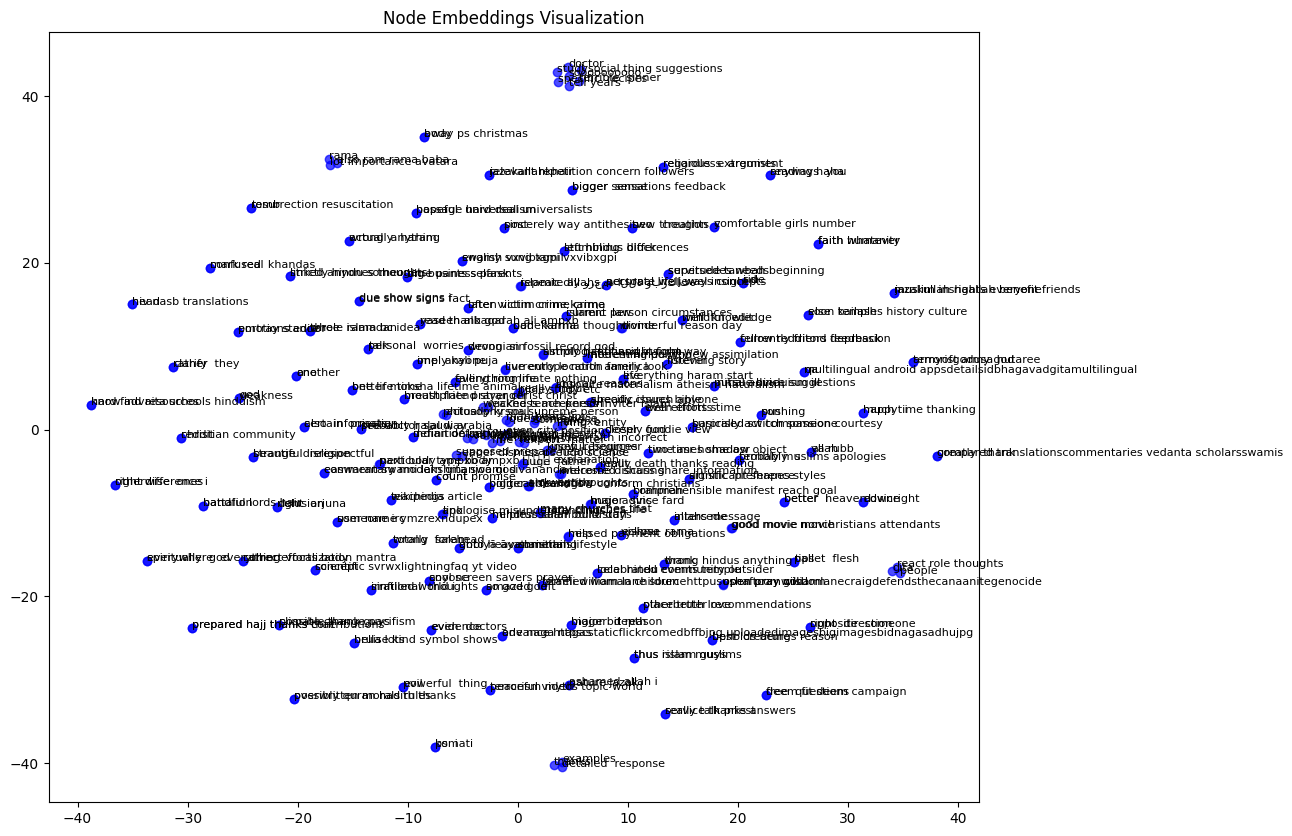

In [38]:
from node2vec import Node2Vec

node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4) # Training the model

from sklearn.manifold import TSNE
import numpy as np

embeddings = np.array([model.wv[node] for node in G.nodes()])
tsne = TSNE(n_components=2, perplexity=10, n_iter=400)
embeddings_2d = tsne.fit_transform(embeddings)
plt.figure(figsize=(12, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue', alpha=0.7)
for i, node in enumerate(G.nodes()):
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], node, fontsize=8)
    plt.title('Node Embeddings Visualization')
plt.show()

## Kmeans with KG

Computing transition probabilities:   0%|          | 0/288 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:04<00:00, 11.75it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


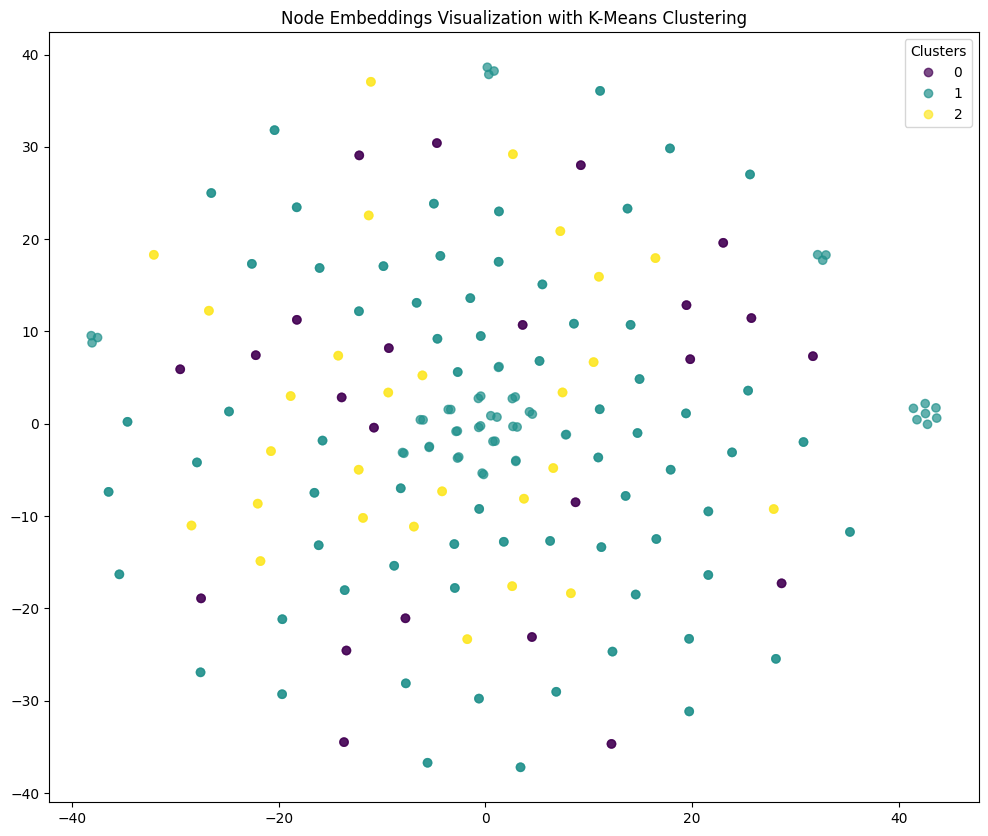

In [39]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

embeddings = np.array([model.wv[node] for node in G.nodes()])

kmeans = KMeans(n_clusters=3, random_state=42)  # You can adjust the number of clusters
cluster_labels = kmeans.fit_predict(embeddings)

tsne = TSNE(n_components=2, perplexity=10, n_iter=400)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title('Node Embeddings Visualization with K-Means Clustering')
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.show()


/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128591 (\N{PERSON WITH FOLDED HANDS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


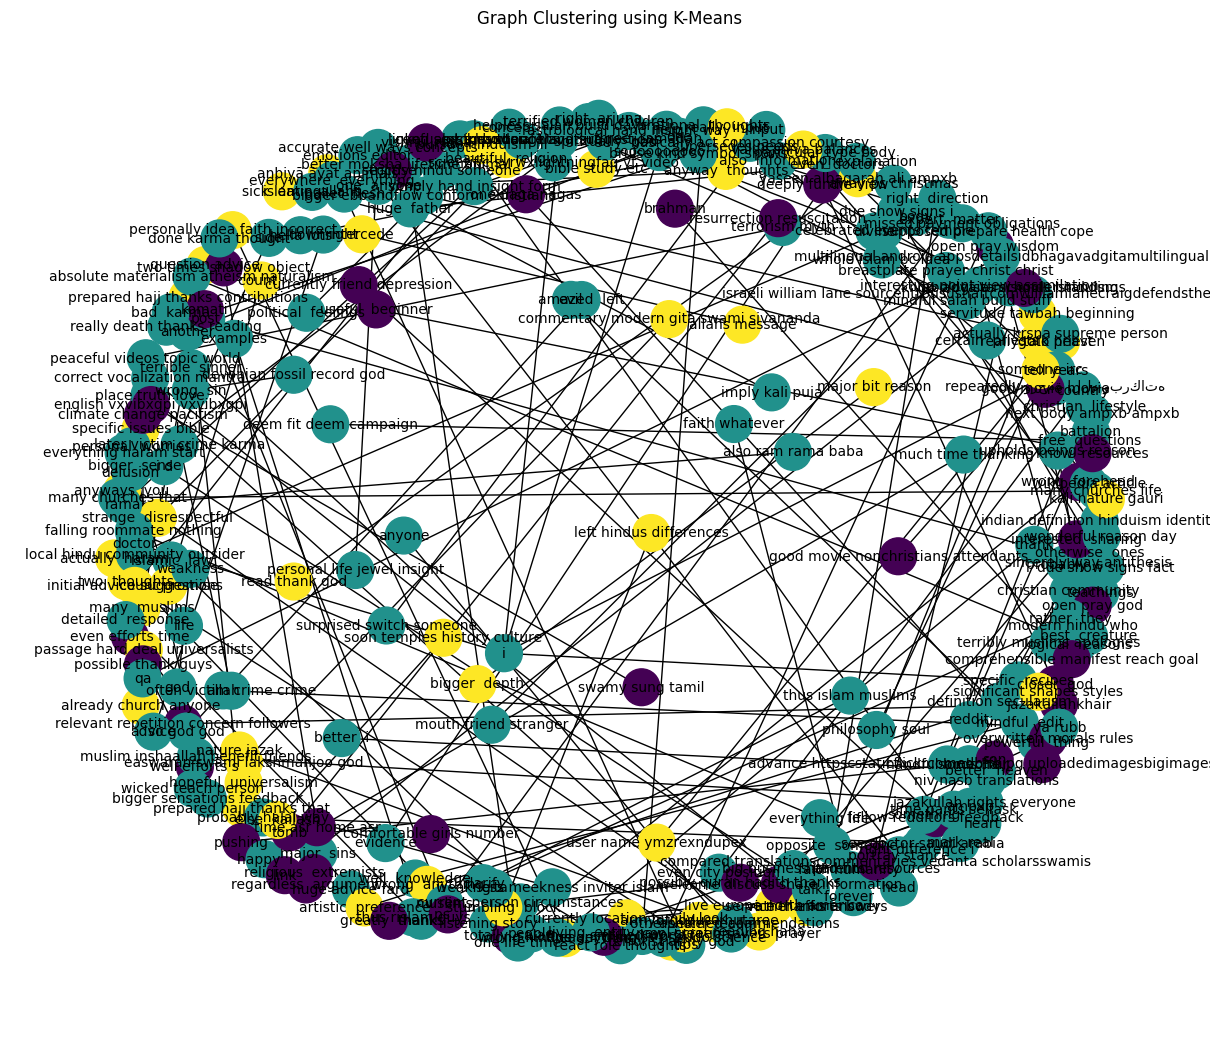

In [40]:
plt.figure(figsize=(12, 10))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=700, node_color=cluster_labels)
plt.title('Graph Clustering using K-Means')
plt.show()

In [41]:
#number of nodes in each cluster
unique, counts = np.unique(cluster_labels, return_counts=True)

print(np.asarray((unique, counts)).T)

[[  0  46]
 [  1 186]
 [  2  56]]


## DB Scan(DensityBased) with KG

In [42]:
pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 33.0 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for cython<3,>=0.27 from https://files.pythonhosted.org/packages/f8/26/ca0f1bb049b83c25cafa39f3fa5287c826a6ab36e665c906209e07f4deac/Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl.metadata (3.1 kB)
Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=819467 sha256=53a821e20675f7736a3783d1321846928098cda596d0d3e6922d353e8bc432f1
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09

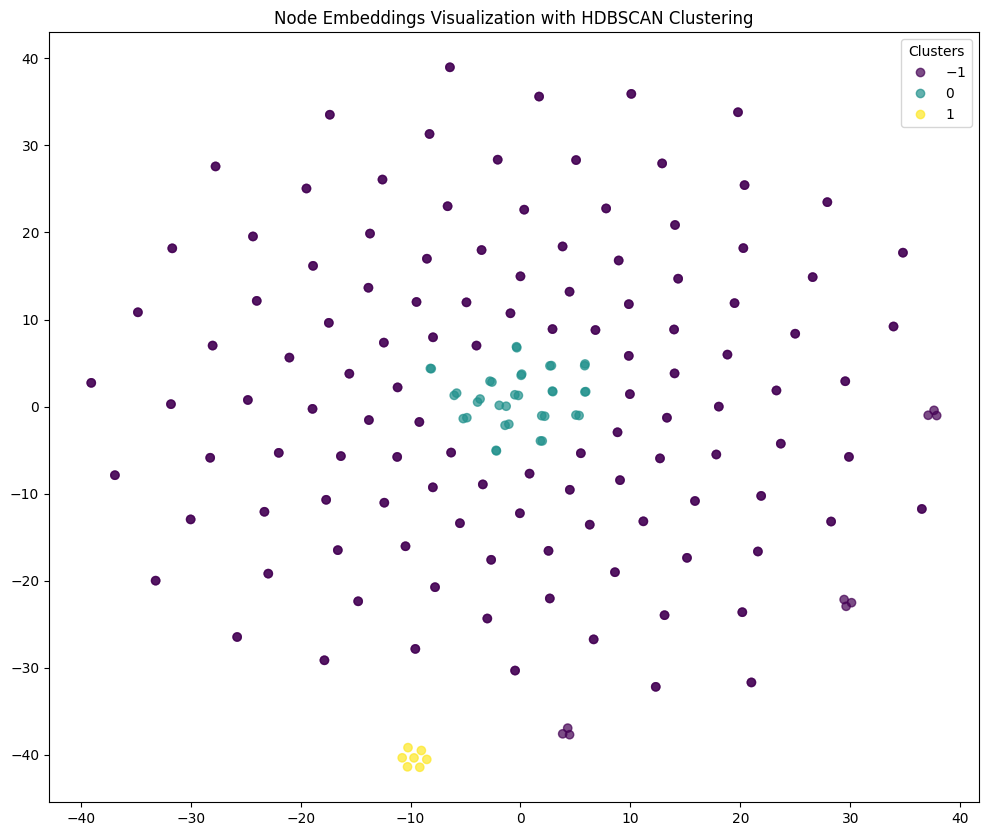

In [43]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=3, metric='euclidean')
cluster_labels = clusterer.fit_predict(embeddings)

# Visualize the clusters using t-SNE
tsne = TSNE(n_components=2, perplexity=10, n_iter=400)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title('Node Embeddings Visualization with HDBSCAN Clustering')
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.show()

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128591 (\N{PERSON WITH FOLDED HANDS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


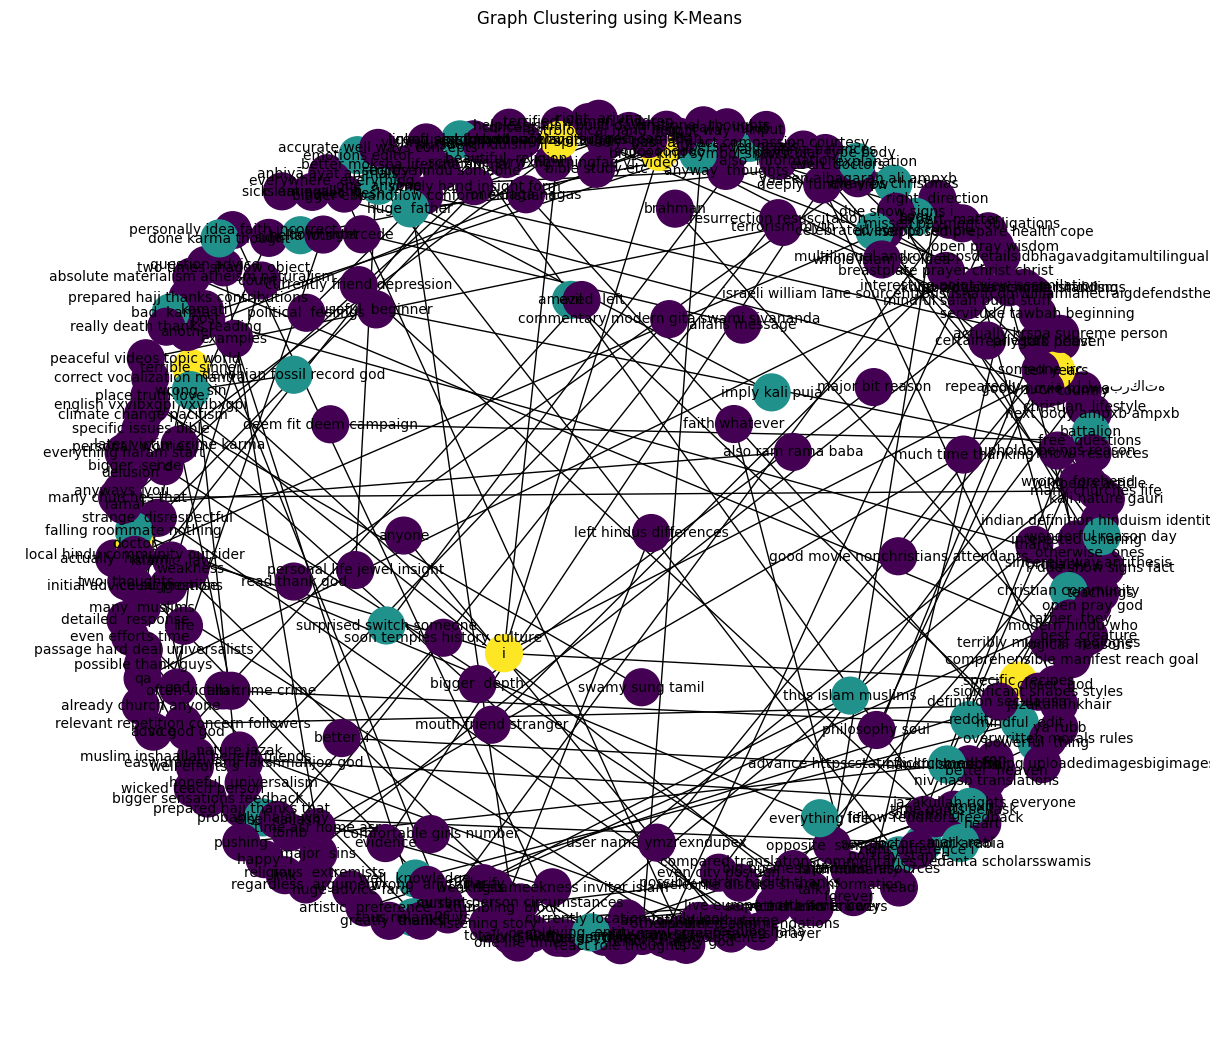

In [44]:
plt.figure(figsize=(12, 10))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=700, node_color=cluster_labels)
plt.title('Graph Clustering using K-Means')
plt.show()

## Kmeans with BertTokenizer

In [58]:
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
import torch

In [61]:
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
import torch

# Tokenize using a BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenized_documents = tokenizer(documents, return_tensors="pt", padding=True, truncation=True)

sub = concatenated_df['Subject'].tolist()
obj = concatenated_df['Object'].tolist()
rel = concatenated_df['relations'].tolist()
documents = [f"{sub} {rel} {obj}" for sub, rel, obj in zip(sub, rel, obj)]

# Load pre-trained BERT model
model = BertModel.from_pretrained("bert-base-uncased")

# Obtain BERT embeddings
with torch.no_grad():
    outputs = model(**tokenized_documents)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Mean pooling

# Convert embeddings to NumPy array
embeddings_np = embeddings.numpy()

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_np)

# Print cluster labels
print("Cluster Labels:", cluster_labels)


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Cluster Labels: [1 0 2 1 1 1 1 1 1 2 2 2 1 0 2 0 2 2 1 2 2 2 0 2 1 2 2 2 1 2 2 1 2 1 1 1 1
 1 1 2 1 1 2 1 2 1 2 0 1 2 0 1 0 0 0 1 1 0 0 2 2 1 1 2 0 2 2 2 1 2 0 1 2 1
 2 2 2 1 2 2 1 2 2 2 2 2 2 2 0 2 2 0 1 0 1 0 2 2 1 2 1 1 1 1 2 1 1 1 1 2 1
 1 1 1 2 0 0 2 1 1 2 2 1 1 1 1 2 1 2 1 2 0 1 1 2 0 1 1 1 1 0 1 2 1 2 1 1 1
 1 2]


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [62]:
concatenated_df['new_clus'] = cluster_labels
concatenated_df

Subject  \
0                            helpless salah build days   
1                            prepared hajj thanks that   
2                                     anyway  thoughts   
3                              see doctor saudi arabia   
4                                         islamic  law   
..                                                 ...   
145                                 also ram rama baba   
146  compared translationscommentaries vedanta scho...   
147                           later victim crime karma   
148                 comprehensible manifest reach goal   
149                                       huge  father   

                                 Object    relations  word_islam  \
0             mindful salah build stuff         came          16   
1    prepared hajj thanks contributions         save           3   
2                          sick  eating          saw           4   
3                    probably halal way       handle           1   
4          current person circumstances      married           1   
..                                  ...          ...         ...   
145                                rama  felt strong           0   
146                      greatly  thank       prefer           0   
147            often victim crime crime       affect           0   
148                             brahman         seen           1   
149                   🙏 🙏 🙏 explanation        asked           0   

     word_hinduism  word_christan  new_clus  
0                0              0         1  
1                0              0         0  
2                0              0         2  
3                0              1         1  
4                0              0         1  
..             ...            ...       ...  
145              2              0         1  
146              2              0         1  
147              0              0         1  
148              2              1         1  
149              0              0         2  

[150 rows x 7 columns]

In [63]:
concatenated_df['new_clus'].head(50).value_counts()

new_clus
1    23
2    22
0     5
Name: count, dtype: int64

## Kmeans with GPT2Tokenizer

In [64]:
from transformers import GPT2Tokenizer, GPT2Model

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2")


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [67]:
from transformers import GPT2Tokenizer, GPT2Model
import torch

# Load pre-trained GPT-2 model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2")

# Add a new padding token
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Set padding token to be the end of sequence token (eos_token)
tokenizer.pad_token = tokenizer.eos_token

# Assuming concatenated_df['Subject'] and concatenated_df['Object'] are Pandas Series
subject_texts = concatenated_df['Subject'].tolist()
object_texts = concatenated_df['Object'].tolist()

# Tokenize subjects and objects separately
subject_tokens = tokenizer(subject_texts, return_tensors="pt", padding=True, truncation=True)
object_tokens = tokenizer(object_texts, return_tensors="pt", padding=True, truncation=True)


In [68]:
with torch.no_grad():
    subject_outputs = model(**subject_tokens)
    object_outputs = model(**object_tokens)

subject_embedding = subject_outputs.last_hidden_state.mean(dim=1).numpy()
object_embedding = object_outputs.last_hidden_state.mean(dim=1).numpy()


In [69]:
subject_embedding /= np.linalg.norm(subject_embedding)
object_embedding /= np.linalg.norm(object_embedding)


In [70]:
combined_embeddings = np.concatenate([subject_embedding, object_embedding], axis=1)

# Normalize combined embeddings
combined_embeddings /= np.linalg.norm(combined_embeddings, axis=1, keepdims=True)


Computing transition probabilities:   0%|          | 0/288 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 50/50 [00:04<00:00, 11.96it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


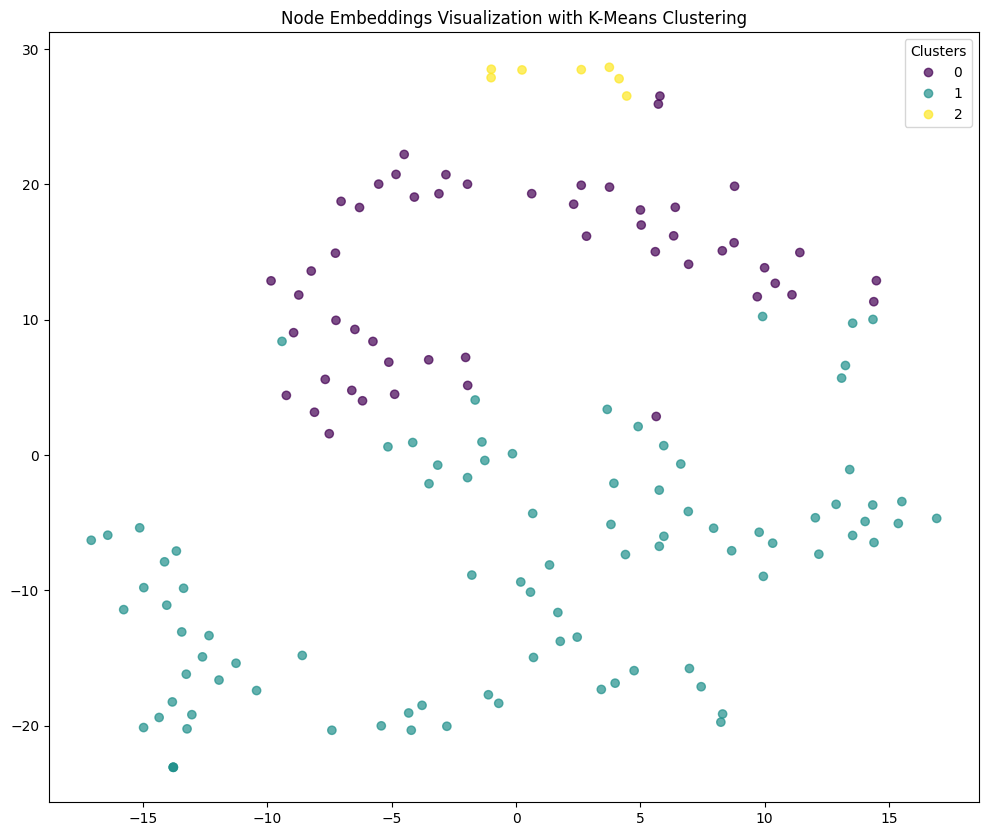

In [71]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

embeddings = np.array([model.wv[node] for node in G.nodes()])

kmeans = KMeans(n_clusters=3, random_state=42)  # You can adjust the number of clusters
cluster_labels = kmeans.fit_predict(combined_embeddings)

tsne = TSNE(n_components=2, perplexity=10, n_iter=400)
embeddings_2d = tsne.fit_transform(combined_embeddings)

plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.title('Node Embeddings Visualization with K-Means Clustering')
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.show()


In [73]:
concatenated_df['new_clus'] = cluster_labels
concatenated_df

Subject  \
0                            helpless salah build days   
1                            prepared hajj thanks that   
2                                     anyway  thoughts   
3                              see doctor saudi arabia   
4                                         islamic  law   
..                                                 ...   
145                                 also ram rama baba   
146  compared translationscommentaries vedanta scho...   
147                           later victim crime karma   
148                 comprehensible manifest reach goal   
149                                       huge  father   

                                 Object    relations  word_islam  \
0             mindful salah build stuff         came          16   
1    prepared hajj thanks contributions         save           3   
2                          sick  eating          saw           4   
3                    probably halal way       handle           1   
4          current person circumstances      married           1   
..                                  ...          ...         ...   
145                                rama  felt strong           0   
146                      greatly  thank       prefer           0   
147            often victim crime crime       affect           0   
148                             brahman         seen           1   
149                   🙏 🙏 🙏 explanation        asked           0   

     word_hinduism  word_christan  new_clus  
0                0              0         1  
1                0              0         1  
2                0              0         1  
3                0              1         0  
4                0              0         1  
..             ...            ...       ...  
145              2              0         1  
146              2              0         1  
147              0              0         0  
148              2              1         1  
149              0              0         1  

[150 rows x 7 columns]

In [74]:
concatenated_df['new_clus'].head(50).value_counts()

new_clus
1    28
0    22
Name: count, dtype: int64